In [7]:
import sys
from pathlib import Path
sys.path.append(str(Path("./multiscale-ssh")))  # replace with real path

from DL_models import UNet  
from DL_models import CNN
from loss_function import CombinedLoss
from train_test import train_model, train_model_r2
from train_test import evaluate_model_sr
from visualization import plot_predictions_vs_targets
from visualization import plot_mean_power_spectrum
from visualization import plot_train_val_losses
from visualization import plot_mean_esr
from dataloading import prepare_dataloaders
from qualitative_eval import mse, r2_score, pearson_corr

In [2]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
import os
import xrft
import gcm_filters
import random
import scipy
from scipy.ndimage import convolve

warnings.filterwarnings("ignore")

# importlib.reload(preprocessing)
# from preprocessing import preprocess_data

# from model_eval_plotting import evaluate_model
# from model_eval_plotting import plot_predictions_vs_targets

# from CNN_setup import SimpleCNN
# from CNN_setup import TensorDataset

# from gcm_filtering import filter_inputs_dataset
# from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

/srv/conda/envs/notebook/lib/python3.12/site-packages/pop_tools/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


# Helper functions

In [3]:
def r2_per_sample(y_true, y_pred):
    n_samples = y_true.shape[0]
    r2_scores = np.empty(n_samples)
    
    for i in range(n_samples):
        yt = y_true[i].reshape(-1)
        yp = y_pred[i].reshape(-1)
        ss_res = np.sum((yt - yp) ** 2)
        ss_tot = np.sum((yt - np.mean(yt)) ** 2)
        r2_scores[i] = 1 - ss_res / ss_tot
    
    return r2_scores

# Data Preprocessing

In [4]:
ds_HR_reg = xr.open_dataset("gs://leap-persistent/panalluri/ds_HR_globalRegions.zarr", engine="zarr", chunks={}) 
ds_LR_reg = xr.open_dataset("gs://leap-persistent/panalluri/ds_LR_globalRegions.zarr", engine="zarr", chunks={}) 
ds_HF_reg = xr.open_dataset("gs://leap-persistent/panalluri/ds_HF_globalRegions.zarr", engine="zarr", chunks={}) 

# u_rel Testing

In [5]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='u_relative', batch_size=32, normalization_type='standardization')

Training set size: 6132
Validation set size: 1314
Testing set size: 1314


In [6]:
model = UNet()
model

UNet(
  (enc_conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv1_1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv2_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [9]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda")

train_losses, val_losses, r2_vals = train_model_r2(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_UNet_stand_global.pth', 
            n_epochs=2000, patience=30, delta=1e-3) # n_epochs=2000) 

Trainable Parameters: 2314881
Resuming from epoch 5 with best r2 values []
Epoch 6, Train Loss: 1.558e-02, Val Loss: 6.666e-03, Val R²: 0.9929, Epoch Time: 33.56s
Model saved at epoch 6
Epoch 7, Train Loss: 1.492e-02, Val Loss: 6.164e-03, Val R²: 0.9934, Epoch Time: 31.27s
Model saved at epoch 7
Epoch 8, Train Loss: 1.389e-02, Val Loss: 5.357e-03, Val R²: 0.9943, Epoch Time: 33.43s
Model saved at epoch 8
Epoch 9, Train Loss: 1.203e-02, Val Loss: 6.389e-03, Val R²: 0.9932, Epoch Time: 31.29s
Model saved at epoch 9
Epoch 10, Train Loss: 1.571e-02, Val Loss: 5.064e-03, Val R²: 0.9946, Epoch Time: 31.16s
Model saved at epoch 10
Epoch 11, Train Loss: 1.339e-02, Val Loss: 4.713e-03, Val R²: 0.9950, Epoch Time: 31.07s
Model saved at epoch 11
Epoch 12, Train Loss: 1.234e-02, Val Loss: 9.252e-03, Val R²: 0.9901, Epoch Time: 31.04s
Model saved at epoch 12
Epoch 13, Train Loss: 1.134e-02, Val Loss: 1.346e-02, Val R²: 0.9856, Epoch Time: 31.04s
Model saved at epoch 13
Epoch 14, Train Loss: 1.163e-

In [10]:
device = torch.device("cuda")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_UNet_stand_global.pth') 
sr_pred

Loaded model parameters from ./model_UNet_stand_global.pth


<xarray.DataArray (time: 1314, yt_ocean: 150, xt_ocean: 150)> Size: 118MB
array([[[-0.36536643, -0.4309713 , -0.46513146, ..., -0.91882926,
         -0.8714682 , -0.76494306],
        [-0.4745172 , -0.42763475, -0.46138054, ..., -0.9553881 ,
         -0.9226922 , -0.90893495],
        [-0.5111775 , -0.46132728, -0.4969722 , ..., -1.0317091 ,
         -1.0254735 , -1.0430944 ],
        ...,
        [-0.9153871 , -0.89496917, -0.8715564 , ..., -1.8428931 ,
         -1.8302536 , -1.6349587 ],
        [-0.9239243 , -0.87529254, -0.8395592 , ..., -1.6967033 ,
         -1.6917322 , -1.521422  ],
        [-0.8471885 , -0.86217535, -0.87375814, ..., -1.6448823 ,
         -1.4639956 , -1.3633062 ]],

       [[ 0.8161358 ,  0.9174882 ,  0.97399044, ...,  1.002564  ,
          0.9002338 ,  0.73608345],
        [ 0.93663037,  0.9291075 ,  0.96109015, ...,  0.9881314 ,
          1.0031756 ,  0.92223966],
        [ 0.9663382 ,  0.95469314,  0.9485072 , ...,  1.0033196 ,
          0.9946598 ,  0.98096347],
...
         -0.99895924, -0.9935899 ],
        [-1.3209833 , -1.4039615 , -1.4010196 , ..., -0.93103415,
         -0.94271946, -0.95664823],
        [-1.1952404 , -1.3216428 , -1.357856  , ..., -0.96588916,
         -0.89982706, -0.8517109 ]],

       [[-0.780205  , -0.9054866 , -0.9783089 , ..., -0.6789388 ,
         -0.62985975, -0.5808329 ],
        [-0.90970147, -0.9790346 , -1.0325508 , ..., -0.77563876,
         -0.7215166 , -0.7220623 ],
        [-1.0255665 , -1.0952117 , -1.1525102 , ..., -0.9306001 ,
         -0.89882267, -0.87448394],
        ...,
        [ 0.89831775,  0.8510763 ,  0.8896983 , ...,  0.18450575,
          0.24316917,  0.09281694],
        [ 0.91728294,  0.8525733 ,  0.8606764 , ...,  0.18506615,
          0.23549484,  0.0932698 ],
        [ 0.8383823 ,  0.8533765 ,  0.9132633 , ...,  0.20079733,
          0.21163644,  0.0747113 ]]],
      shape=(1314, 150, 150), dtype=float32)
Coordinates:
  * time      (time) int64 11kB 8726 7208 5637 4143 2423 ... 4979 8172 5685 4785
  * yt_ocean  (yt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * xt_ocean  (xt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150

In [11]:
r2_scores_urel = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_urel)
best_r2 = r2_scores_urel[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9995 at index 911


In [12]:
mean, std = norm_stats
urel_HR_test = HR_test * std + mean
urel_LR_test = LR_test * std + mean
urel_sr_pred = sr_pred * std + mean

# v_rel Testing

In [13]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='v_relative', batch_size=32, normalization_type='standardization')

Training set size: 6132
Validation set size: 1314
Testing set size: 1314


In [14]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda")

train_losses, val_losses, r2_vals = train_model_r2(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_UNet_vrel_stand_global.pth', 
            n_epochs=2000, patience=30, delta=1e-3) # n_epochs=2000) 

Trainable Parameters: 2314881
Epoch 1, Train Loss: 1.457e-02, Val Loss: 6.930e-03, Val R²: 0.9932, Epoch Time: 31.81s
Model saved at epoch 1
Epoch 2, Train Loss: 1.255e-02, Val Loss: 7.132e-03, Val R²: 0.9930, Epoch Time: 31.08s
Model saved at epoch 2
Epoch 3, Train Loss: 1.303e-02, Val Loss: 4.492e-03, Val R²: 0.9956, Epoch Time: 30.91s
Model saved at epoch 3
Epoch 4, Train Loss: 1.126e-02, Val Loss: 4.050e-03, Val R²: 0.9960, Epoch Time: 31.30s
Model saved at epoch 4
Epoch 5, Train Loss: 1.487e-02, Val Loss: 4.025e-03, Val R²: 0.9961, Epoch Time: 31.16s
Model saved at epoch 5
Epoch 6, Train Loss: 1.209e-02, Val Loss: 2.883e-03, Val R²: 0.9972, Epoch Time: 31.05s
Model saved at epoch 6
Epoch 7, Train Loss: 1.370e-02, Val Loss: 3.666e-03, Val R²: 0.9964, Epoch Time: 31.16s
Model saved at epoch 7
Epoch 8, Train Loss: 1.182e-02, Val Loss: 2.595e-03, Val R²: 0.9975, Epoch Time: 31.23s
Model saved at epoch 8
Epoch 9, Train Loss: 1.185e-02, Val Loss: 3.691e-03, Val R²: 0.9964, Epoch Time: 3

In [15]:
device = torch.device("cuda")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_UNet_vrel_stand_global.pth')
sr_pred

Loaded model parameters from ./model_UNet_vrel_stand_global.pth


<xarray.DataArray (time: 1314, yt_ocean: 150, xt_ocean: 150)> Size: 118MB
array([[[ 0.3744418 ,  0.41294658,  0.44432127, ..., -0.84740955,
         -0.80069065, -0.7010363 ],
        [ 0.4422214 ,  0.40128088,  0.40885633, ..., -0.8033131 ,
         -0.81110144, -0.77331334],
        [ 0.45934188,  0.42534995,  0.42384648, ..., -0.85754377,
         -0.8631274 , -0.9110495 ],
        ...,
        [ 1.0273004 ,  0.9793018 ,  1.0277628 , ..., -0.30416214,
         -0.34581953, -0.34979016],
        [ 0.9597314 ,  0.92859787,  1.0076268 , ..., -0.33843428,
         -0.31873333, -0.37335664],
        [ 0.8521444 ,  0.9934002 ,  1.0860366 , ..., -0.37958276,
         -0.3338278 , -0.33268267]],

       [[ 0.77893406,  0.90616655,  0.9544385 , ...,  0.2901591 ,
          0.2870052 ,  0.243248  ],
        [ 0.8991854 ,  0.91960406,  0.9362214 , ...,  0.27151698,
          0.30083603,  0.26611006],
        [ 0.95011574,  0.9320695 ,  0.92737347, ...,  0.27190214,
          0.2812044 ,  0.28797948],
...
          1.5275373 ,  1.503946  ],
        [ 0.34009427,  0.32657087,  0.3561477 , ...,  1.5437723 ,
          1.5601056 ,  1.3823614 ],
        [ 0.2741645 ,  0.3483457 ,  0.39769912, ...,  1.6002176 ,
          1.5480742 ,  1.195094  ]],

       [[-0.26278228, -0.3131914 , -0.38276017, ..., -2.1712072 ,
         -2.1154168 , -1.715806  ],
        [-0.28619123, -0.36398965, -0.39893013, ..., -2.1723733 ,
         -2.186551  , -1.999363  ],
        [-0.29102564, -0.35517246, -0.40150177, ..., -2.1651242 ,
         -2.3001149 , -2.3234637 ],
        ...,
        [-0.25026453, -0.1534257 , -0.18924117, ..., -1.545987  ,
         -1.6693194 , -1.6159176 ],
        [-0.15196684, -0.14806701, -0.12667218, ..., -1.6134284 ,
         -1.6155721 , -1.5561154 ],
        [-0.20886387, -0.11836538, -0.17058463, ..., -1.6442329 ,
         -1.5262295 , -1.3517213 ]]],
      shape=(1314, 150, 150), dtype=float32)
Coordinates:
  * time      (time) int64 11kB 621 7843 1606 6286 759 ... 4711 4466 6199 6752
  * yt_ocean  (yt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * xt_ocean  (xt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150

In [16]:
r2_scores_vrel = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_vrel)
best_r2 = r2_scores_vrel[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9993 at index 579


In [17]:
mean, std = norm_stats
vrel_HR_test = HR_test * std + mean
vrel_LR_test = LR_test * std + mean
vrel_sr_pred = sr_pred * std + mean

# t_ref Testing

In [18]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='t_ref', batch_size=32, normalization_type='standardization')

Training set size: 6132
Validation set size: 1314
Testing set size: 1314


In [19]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda")

train_losses, val_losses, r2_vals = train_model_r2(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_UNet_tref_stand_global.pth', 
            n_epochs=2000, patience=30, delta=1e-3) # n_epochs=2000) 

Trainable Parameters: 2314881
Epoch 1, Train Loss: 6.063e-03, Val Loss: 1.879e-03, Val R²: 0.9981, Epoch Time: 31.71s
Model saved at epoch 1
Epoch 2, Train Loss: 7.056e-03, Val Loss: 1.970e-03, Val R²: 0.9980, Epoch Time: 31.00s
Model saved at epoch 2
Epoch 3, Train Loss: 5.052e-03, Val Loss: 9.830e-04, Val R²: 0.9990, Epoch Time: 30.80s
Model saved at epoch 3
Epoch 4, Train Loss: 3.695e-03, Val Loss: 6.055e-04, Val R²: 0.9994, Epoch Time: 31.19s
Model saved at epoch 4
Epoch 5, Train Loss: 3.708e-03, Val Loss: 1.424e-03, Val R²: 0.9986, Epoch Time: 31.07s
Model saved at epoch 5
Epoch 6, Train Loss: 4.314e-03, Val Loss: 1.141e-03, Val R²: 0.9988, Epoch Time: 30.97s
Model saved at epoch 6
Epoch 7, Train Loss: 3.271e-03, Val Loss: 5.783e-04, Val R²: 0.9994, Epoch Time: 31.08s
Model saved at epoch 7
Epoch 8, Train Loss: 4.455e-03, Val Loss: 8.192e-04, Val R²: 0.9992, Epoch Time: 31.04s
Model saved at epoch 8
Epoch 9, Train Loss: 2.927e-03, Val Loss: 1.478e-03, Val R²: 0.9985, Epoch Time: 3

In [20]:
device = torch.device("cuda")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_UNet_tref_stand_global.pth')
sr_pred

Loaded model parameters from ./model_UNet_tref_stand_global.pth


<xarray.DataArray (time: 1314, yt_ocean: 150, xt_ocean: 150)> Size: 118MB
array([[[-0.3552661 , -0.5374291 , -0.53707343, ..., -0.7515269 ,
         -0.73847675, -0.6534429 ],
        [-0.47674182, -0.5190103 , -0.51579726, ..., -0.76704043,
         -0.77567154, -0.7842897 ],
        [-0.49186602, -0.5001372 , -0.4921446 , ..., -0.7384417 ,
         -0.7475611 , -0.80643106],
        ...,
        [ 0.18281543,  0.20452243,  0.21785681, ...,  0.17086582,
          0.14811291,  0.08381583],
        [ 0.1474594 ,  0.18139645,  0.2322623 , ...,  0.13400577,
          0.12162939,  0.06052024],
        [ 0.17427403,  0.18940616,  0.23158336, ...,  0.13525416,
          0.14064237,  0.15391435]],

       [[ 0.981307  ,  1.1027308 ,  1.1646792 , ...,  1.1642767 ,
          1.0698423 ,  0.9611955 ],
        [ 1.1045473 ,  1.1467106 ,  1.166888  , ...,  1.1747983 ,
          1.1708696 ,  1.0621929 ],
        [ 1.1432501 ,  1.163142  ,  1.166432  , ...,  1.179386  ,
          1.1803017 ,  1.1641544 ],
...
         -0.7376032 , -0.7652888 ],
        [-0.69768554, -0.6830585 , -0.656338  , ..., -0.70703244,
         -0.69500494, -0.7586877 ],
        [-0.6558789 , -0.70386946, -0.7082016 , ..., -0.749092  ,
         -0.7191156 , -0.6772707 ]],

       [[ 0.86422676,  0.9349142 ,  0.9788872 , ...,  0.9228385 ,
          0.8552997 ,  0.81196874],
        [ 0.9589065 ,  0.975585  ,  0.98853207, ...,  0.95487446,
          0.94082093,  0.87040687],
        [ 0.9947276 ,  0.9970817 ,  0.99152803, ...,  0.97578734,
          0.9633979 ,  0.962084  ],
        ...,
        [ 1.1112729 ,  1.1075563 ,  1.1098744 , ...,  1.300327  ,
          1.3316832 ,  1.2974739 ],
        [ 1.056248  ,  1.0565736 ,  1.095211  , ...,  1.302104  ,
          1.3063092 ,  1.2330185 ],
        [ 0.98091906,  1.083847  ,  1.134265  , ...,  1.3432899 ,
          1.2966353 ,  1.1374305 ]]],
      shape=(1314, 150, 150), dtype=float32)
Coordinates:
  * time      (time) int64 11kB 4361 7345 252 1619 883 ... 4631 8507 5840 1835
  * yt_ocean  (yt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * xt_ocean  (xt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150

In [21]:
r2_scores_tref = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_tref)
best_r2 = r2_scores_tref[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9992 at index 1246


In [22]:
mean, std = norm_stats
tref_HR_test = HR_test * std + mean
tref_LR_test = LR_test * std + mean
tref_sr_pred = sr_pred * std + mean

# q_ref Testing

In [23]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='q_ref', batch_size=32, normalization_type='standardization')

Training set size: 6132
Validation set size: 1314
Testing set size: 1314


In [24]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda")

train_losses, val_losses, r2_vals = train_model_r2(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_UNet_qref_stand_global.pth', 
            n_epochs=2000, patience=30, delta=1e-3) # n_epochs=2000) 

Trainable Parameters: 2314881
Epoch 1, Train Loss: 2.991e-03, Val Loss: 1.022e-03, Val R²: 0.9990, Epoch Time: 31.72s
Model saved at epoch 1
Epoch 2, Train Loss: 2.862e-03, Val Loss: 2.026e-03, Val R²: 0.9980, Epoch Time: 31.01s
Model saved at epoch 2
Epoch 3, Train Loss: 2.317e-03, Val Loss: 7.823e-04, Val R²: 0.9992, Epoch Time: 30.85s
Model saved at epoch 3
Epoch 4, Train Loss: 2.636e-03, Val Loss: 6.820e-04, Val R²: 0.9993, Epoch Time: 31.20s
Model saved at epoch 4
Epoch 5, Train Loss: 2.194e-03, Val Loss: 9.562e-04, Val R²: 0.9991, Epoch Time: 31.04s
Model saved at epoch 5
Epoch 6, Train Loss: 2.636e-03, Val Loss: 1.729e-03, Val R²: 0.9983, Epoch Time: 30.96s
Model saved at epoch 6
Epoch 7, Train Loss: 2.440e-03, Val Loss: 1.020e-03, Val R²: 0.9990, Epoch Time: 31.06s
Model saved at epoch 7
Epoch 8, Train Loss: 2.075e-03, Val Loss: 1.101e-03, Val R²: 0.9989, Epoch Time: 31.08s
Model saved at epoch 8
Epoch 9, Train Loss: 2.211e-03, Val Loss: 9.553e-04, Val R²: 0.9991, Epoch Time: 3

In [25]:
device = torch.device("cuda")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_UNet_qref_stand_global.pth')
sr_pred

Loaded model parameters from ./model_UNet_qref_stand_global.pth


<xarray.DataArray (time: 1314, yt_ocean: 150, xt_ocean: 150)> Size: 118MB
array([[[-1.178435  , -1.3433738 , -1.3810457 , ..., -1.1911764 ,
         -1.171651  , -1.0653538 ],
        [-1.3333856 , -1.4041678 , -1.3729299 , ..., -1.1964207 ,
         -1.2020459 , -1.1668313 ],
        [-1.3587053 , -1.3994755 , -1.3661652 , ..., -1.1963483 ,
         -1.2114486 , -1.2449337 ],
        ...,
        [-0.8360564 , -0.82546884, -0.82625794, ..., -0.8868446 ,
         -0.90901786, -0.89411134],
        [-0.84414893, -0.8357263 , -0.8100614 , ..., -0.90219146,
         -0.8789596 , -0.8860237 ],
        [-0.76427996, -0.8125203 , -0.8346665 , ..., -0.915245  ,
         -0.86018944, -0.8147214 ]],

       [[ 1.4331669 ,  1.617066  ,  1.6855847 , ...,  1.6189442 ,
          1.52816   ,  1.302697  ],
        [ 1.5947218 ,  1.694607  ,  1.7231036 , ...,  1.6513526 ,
          1.6308578 ,  1.4690421 ],
        [ 1.6467742 ,  1.7024721 ,  1.7148802 , ...,  1.621997  ,
          1.6184947 ,  1.5647569 ],
...
         -0.51663274, -0.5429937 ],
        [-0.9352716 , -0.9325922 , -0.90346473, ..., -0.52065074,
         -0.5037009 , -0.5471078 ],
        [-0.8606473 , -0.89557624, -0.9182344 , ..., -0.5185829 ,
         -0.5191035 , -0.46840224]],

       [[ 1.2727717 ,  1.4261117 ,  1.4696654 , ...,  1.0096469 ,
          0.9688012 ,  0.8682616 ],
        [ 1.4030077 ,  1.4646068 ,  1.4831065 , ...,  1.0010535 ,
          0.97120017,  0.93129414],
        [ 1.4359865 ,  1.4730375 ,  1.4660574 , ...,  0.98885745,
          0.97546977,  0.9782787 ],
        ...,
        [ 1.0351166 ,  1.0112286 ,  1.0120312 , ...,  1.2585435 ,
          1.264762  ,  1.2637357 ],
        [ 0.9750295 ,  0.9353415 ,  0.98068696, ...,  1.2462747 ,
          1.2589065 ,  1.23984   ],
        [ 0.95393723,  1.0080884 ,  1.035076  , ...,  1.322319  ,
          1.3134292 ,  1.1835291 ]]],
      shape=(1314, 150, 150), dtype=float32)
Coordinates:
  * time      (time) int64 11kB 5886 5597 1406 1410 5333 ... 7603 5100 2918 1866
  * yt_ocean  (yt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * xt_ocean  (xt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150

In [26]:
r2_scores_qref = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_qref)
best_r2 = r2_scores_qref[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9990 at index 1062


In [27]:
mean, std = norm_stats
qref_HR_test = HR_test * std + mean
qref_LR_test = LR_test * std + mean
qref_sr_pred = sr_pred * std + mean

# SLP Testing

In [28]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='slp', batch_size=32, normalization_type='standardization')

Training set size: 6132
Validation set size: 1314
Testing set size: 1314


In [29]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda")

train_losses, val_losses, r2_vals = train_model_r2(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_UNet_slp_stand_global.pth', 
            n_epochs=2000, patience=30, delta=1e-3) # n_epochs=2000) 

Trainable Parameters: 2314881
Epoch 1, Train Loss: 1.554e-02, Val Loss: 2.094e-03, Val R²: 0.9976, Epoch Time: 31.71s
Model saved at epoch 1
Epoch 2, Train Loss: 1.321e-02, Val Loss: 7.131e-04, Val R²: 0.9991, Epoch Time: 30.95s
Model saved at epoch 2
Epoch 3, Train Loss: 1.517e-02, Val Loss: 6.327e-04, Val R²: 0.9993, Epoch Time: 30.78s
Model saved at epoch 3
Epoch 4, Train Loss: 1.186e-02, Val Loss: 1.352e-03, Val R²: 0.9985, Epoch Time: 31.15s
Model saved at epoch 4
Epoch 5, Train Loss: 1.237e-02, Val Loss: 4.387e-03, Val R²: 0.9951, Epoch Time: 31.02s
Model saved at epoch 5
Epoch 6, Train Loss: 1.218e-02, Val Loss: 1.176e-03, Val R²: 0.9986, Epoch Time: 30.93s
Model saved at epoch 6
Epoch 7, Train Loss: 9.899e-03, Val Loss: 3.564e-03, Val R²: 0.9962, Epoch Time: 30.94s
Model saved at epoch 7
Epoch 8, Train Loss: 1.277e-02, Val Loss: 3.695e-03, Val R²: 0.9959, Epoch Time: 30.96s
Model saved at epoch 8
Epoch 9, Train Loss: 9.688e-03, Val Loss: 1.091e-03, Val R²: 0.9988, Epoch Time: 3

In [30]:
device = torch.device("cuda")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_UNet_slp_stand_global.pth')
sr_pred

Loaded model parameters from ./model_UNet_slp_stand_global.pth


<xarray.DataArray (time: 1314, yt_ocean: 150, xt_ocean: 150)> Size: 118MB
array([[[-0.6567324 , -0.8006468 , -0.78268015, ..., -0.23702875,
         -0.19003677, -0.12627238],
        [-0.7827648 , -0.7930833 , -0.7377565 , ..., -0.21614759,
         -0.21670228, -0.2108621 ],
        [-0.80778456, -0.8184571 , -0.77639383, ..., -0.2561732 ,
         -0.23656493, -0.24371347],
        ...,
        [-0.7146    , -0.6742353 , -0.71482825, ..., -0.16013172,
         -0.16593876, -0.19720884],
        [-0.6598502 , -0.73214966, -0.6954008 , ..., -0.21483444,
         -0.1799761 , -0.23539445],
        [-0.6483691 , -0.7085957 , -0.7364602 , ..., -0.23927164,
         -0.18731874, -0.23884806]],

       [[-2.2415888 , -2.6051865 , -2.6446278 , ..., -3.0932972 ,
         -3.0231607 , -2.758471  ],
        [-2.576712  , -2.7202258 , -2.672132  , ..., -3.137278  ,
         -3.1784744 , -3.0253181 ],
        [-2.6527116 , -2.7376623 , -2.700056  , ..., -3.1761618 ,
         -3.303879  , -3.2945983 ],
...
          0.49066934,  0.51096356],
        [ 0.3605868 ,  0.4096621 ,  0.42692372, ...,  0.4879558 ,
          0.4926316 ,  0.4506941 ],
        [ 0.38792455,  0.41815355,  0.4307721 , ...,  0.5165398 ,
          0.49662954,  0.46006876]],

       [[-3.0273893 , -3.4582443 , -3.5274587 , ..., -1.8294106 ,
         -1.7751632 , -1.66921   ],
        [-3.45831   , -3.5922596 , -3.5517929 , ..., -1.8145435 ,
         -1.8438175 , -1.7804478 ],
        [-3.5975869 , -3.653     , -3.5584786 , ..., -1.8583461 ,
         -1.8883889 , -1.9375374 ],
        ...,
        [-0.42430615, -0.356562  , -0.37954518, ...,  0.15169472,
          0.15328082,  0.08215892],
        [-0.39815193, -0.42083487, -0.3876763 , ...,  0.14864585,
          0.12715113,  0.06170838],
        [-0.3839161 , -0.39733252, -0.4018497 , ...,  0.16121005,
          0.15677235,  0.15090188]]],
      shape=(1314, 150, 150), dtype=float32)
Coordinates:
  * time      (time) int64 11kB 2509 6683 133 7274 3860 ... 8415 498 5317 6794
  * yt_ocean  (yt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * xt_ocean  (xt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150

In [31]:
r2_scores_slp = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_slp)
best_r2 = r2_scores_slp[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9997 at index 219


In [32]:
mean, std = norm_stats
slp_HR_test = HR_test * std + mean
slp_LR_test = LR_test * std + mean
slp_sr_pred = sr_pred * std + mean

# SST Testing

In [33]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='surface_temp', batch_size=32, normalization_type='standardization')

Training set size: 6132
Validation set size: 1314
Testing set size: 1314


In [34]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda")

train_losses, val_losses, r2_vals = train_model_r2(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_UNet_sst_stand_global.pth', 
            n_epochs=2000, patience=30, delta=1e-3) # n_epochs=2000) 

Trainable Parameters: 2314881
Epoch 1, Train Loss: 5.025e-03, Val Loss: 2.641e-03, Val R²: 0.9970, Epoch Time: 31.73s
Model saved at epoch 1
Epoch 2, Train Loss: 3.819e-03, Val Loss: 2.427e-03, Val R²: 0.9973, Epoch Time: 31.01s
Model saved at epoch 2
Epoch 3, Train Loss: 3.192e-03, Val Loss: 2.393e-03, Val R²: 0.9973, Epoch Time: 30.79s
Model saved at epoch 3
Epoch 4, Train Loss: 2.905e-03, Val Loss: 3.372e-03, Val R²: 0.9964, Epoch Time: 31.20s
Model saved at epoch 4
Epoch 5, Train Loss: 2.782e-03, Val Loss: 2.293e-03, Val R²: 0.9975, Epoch Time: 31.07s
Model saved at epoch 5
Epoch 6, Train Loss: 3.736e-03, Val Loss: 1.991e-03, Val R²: 0.9978, Epoch Time: 31.01s
Model saved at epoch 6
Epoch 7, Train Loss: 3.027e-03, Val Loss: 1.776e-03, Val R²: 0.9980, Epoch Time: 31.07s
Model saved at epoch 7
Epoch 8, Train Loss: 2.713e-03, Val Loss: 1.631e-03, Val R²: 0.9982, Epoch Time: 31.12s
Model saved at epoch 8
Epoch 9, Train Loss: 2.744e-03, Val Loss: 1.769e-03, Val R²: 0.9980, Epoch Time: 3

In [35]:
device = torch.device("cuda")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_UNet_sst_stand_global.pth')
sr_pred

Loaded model parameters from ./model_UNet_sst_stand_global.pth


<xarray.DataArray (time: 1314, yt_ocean: 150, xt_ocean: 150)> Size: 118MB
array([[[ 2.87222955e-02, -3.55546474e-02, -4.38612849e-02, ...,
         -7.01367557e-02, -5.46750501e-02,  5.28931394e-02],
        [-1.25816166e-02, -7.06653744e-02, -5.87476939e-02, ...,
         -7.83204734e-02, -8.66486654e-02, -2.59092078e-02],
        [-8.25943053e-03, -5.23887128e-02, -5.06962463e-02, ...,
         -7.01427832e-02, -7.93990642e-02, -2.48685777e-02],
        ...,
        [ 5.82957387e-01,  5.31266928e-01,  5.27146637e-01, ...,
          3.00516993e-01,  3.18742603e-01,  3.43054295e-01],
        [ 5.23257792e-01,  5.15933216e-01,  5.15155733e-01, ...,
          3.29913288e-01,  3.35845381e-01,  3.05866212e-01],
        [ 4.96642172e-01,  5.53915799e-01,  5.57566345e-01, ...,
          3.15327942e-01,  3.31588298e-01,  3.22704226e-01]],

       [[-1.45678067e+00, -1.59034181e+00, -1.63181436e+00, ...,
         -1.95606434e+00, -1.94489634e+00, -1.83675051e+00],
        [-1.56177163e+00, -1.62663674e+00, -1.61134267e+00, ...,
         -1.96099722e+00, -1.95739734e+00, -1.90717971e+00],
        [-1.56994772e+00, -1.60273421e+00, -1.59583819e+00, ...,
         -1.99350441e+00, -2.01456213e+00, -2.00220203e+00],
...
         -3.60580593e-01, -4.07121718e-01, -4.38630521e-01],
        [-1.14614141e+00, -1.24996901e+00, -1.22409415e+00, ...,
         -3.90769213e-01, -3.97363365e-01, -4.42321807e-01],
        [-9.72099721e-01, -1.10024989e+00, -1.18656850e+00, ...,
         -4.15222198e-01, -3.96295786e-01, -3.96286875e-01]],

       [[-1.26181448e+00, -1.38491583e+00, -1.40450990e+00, ...,
         -1.70088029e+00, -1.70302153e+00, -1.61811101e+00],
        [-1.35991728e+00, -1.41175294e+00, -1.39237070e+00, ...,
         -1.69575059e+00, -1.69407547e+00, -1.65169632e+00],
        [-1.36321604e+00, -1.38909686e+00, -1.37427294e+00, ...,
         -1.71830881e+00, -1.73088217e+00, -1.72823942e+00],
        ...,
        [-7.47525454e-01, -7.12875843e-01, -7.19028175e-01, ...,
         -8.94344687e-01, -9.38560545e-01, -9.22233820e-01],
        [-7.03904033e-01, -7.11825013e-01, -6.88955247e-01, ...,
         -9.17928398e-01, -8.84302497e-01, -8.82089913e-01],
        [-6.49973989e-01, -6.83092594e-01, -6.97340429e-01, ...,
         -9.13589716e-01, -8.47882986e-01, -8.07165682e-01]]],
      shape=(1314, 150, 150), dtype=float32)
Coordinates:
  * time      (time) int64 11kB 1366 2776 4559 1717 7552 ... 1039 4692 4768 2336
  * yt_ocean  (yt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * xt_ocean  (xt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150

In [36]:
r2_scores_sst = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_sst)
best_r2 = r2_scores_sst[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9959 at index 452


In [37]:
mean, std = norm_stats
sst_HR_test = HR_test * std + mean
sst_LR_test = LR_test * std + mean
sst_sr_pred = sr_pred * std + mean

# Figures

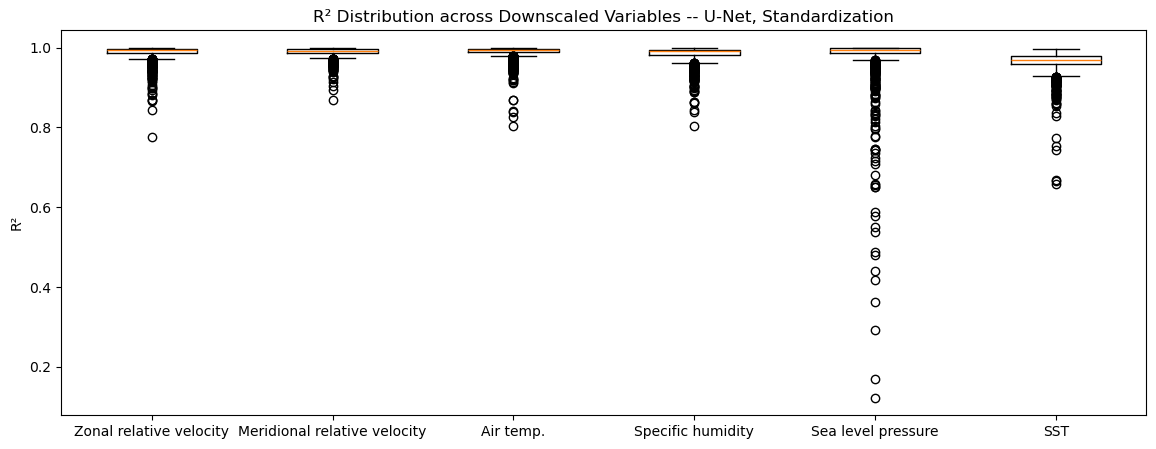

In [38]:
data = [r2_scores_urel, r2_scores_vrel, r2_scores_tref, r2_scores_qref, r2_scores_slp, r2_scores_sst]

plt.figure(figsize=(14, 5))
plt.boxplot(data, vert=True)  # each array becomes a separate boxplot
plt.xticks([1, 2, 3, 4, 5, 6], ["Zonal relative velocity", "Meridional relative velocity", 
                                        "Air temp.", "Specific humidity", "Sea level pressure", "SST"])  # label each box
plt.ylabel("R²")
plt.title("R² Distribution across Downscaled Variables -- U-Net, Standardization")
plt.show()

In [39]:
# Suppose you have 6 arrays: a1, a2, ..., a6 (all same length)
arrays = [r2_scores_urel, r2_scores_vrel, r2_scores_tref, r2_scores_qref, r2_scores_slp, r2_scores_sst]

# Stack into shape (6, N) and take mean over axis=0
mean_array = np.mean(np.stack(arrays, axis=0), axis=0)

# Find the max value and its index
max_val = np.max(mean_array)
max_idx = np.argmax(mean_array)

print(f"Max value = {max_val}, at index = {max_idx}")

Max value = 0.9961428940296173, at index = 873


In [40]:
# Find the min value and its index
min_val = np.min(mean_array)
min_idx = np.argmin(mean_array)

print(f"Min value = {min_val}, at index = {min_idx}")

Min value = 0.84189040462176, at index = 957


In [43]:
# Make a Dataset
ds_unet_stand = xr.Dataset()

# Manually add variables
ds_unet_stand["u_rel_sr"] = (("time", "y", "x"), urel_sr_pred.values)
ds_unet_stand["v_rel_sr"] = (("time", "y", "x"), vrel_sr_pred.values)
ds_unet_stand["t_ref_sr"] = (("time", "y", "x"), tref_sr_pred.values)
ds_unet_stand["q_ref_sr"] = (("time", "y", "x"), qref_sr_pred.values)
ds_unet_stand["slp_sr"] = (("time", "y", "x"), slp_sr_pred.values)
ds_unet_stand["sst_sr"] = (("time", "y", "x"), sst_sr_pred.values)

ds_unet_stand["u_rel_hr"] = (("time", "y", "x"), urel_HR_test.values)
ds_unet_stand["v_rel_hr"] = (("time", "y", "x"), vrel_HR_test.values)
ds_unet_stand["t_ref_hr"] = (("time", "y", "x"), tref_HR_test.values)
ds_unet_stand["q_ref_hr"] = (("time", "y", "x"), qref_HR_test.values)
ds_unet_stand["slp_hr"] = (("time", "y", "x"), slp_HR_test.values)
ds_unet_stand["sst_hr"] = (("time", "y", "x"), sst_HR_test.values)

ds_unet_stand["u_rel_lr"] = (("time", "y", "x"), urel_LR_test)
ds_unet_stand["v_rel_lr"] = (("time", "y", "x"), vrel_LR_test)
ds_unet_stand["t_ref_lr"] = (("time", "y", "x"), tref_LR_test)
ds_unet_stand["q_ref_lr"] = (("time", "y", "x"), qref_LR_test)
ds_unet_stand["slp_lr"] = (("time", "y", "x"), slp_LR_test)
ds_unet_stand["sst_lr"] = (("time", "y", "x"), sst_LR_test)

print(ds_unet_stand)

<xarray.Dataset> Size: 2GB
Dimensions:   (time: 1314, y: 150, x: 150)
Dimensions without coordinates: time, y, x
Data variables: (12/18)
    u_rel_sr  (time, y, x) float32 118MB -1.566 -1.993 -2.215 ... 2.12 2.191 1.3
    v_rel_sr  (time, y, x) float32 118MB 1.761 1.943 2.091 ... -7.214 -6.39
    t_ref_sr  (time, y, x) float32 118MB 285.6 284.1 284.1 ... 300.3 299.9 298.6
    q_ref_sr  (time, y, x) float32 118MB 0.004369 0.00357 ... 0.01644 0.01581
    slp_sr    (time, y, x) float32 118MB 1.004e+05 1.002e+05 ... 1.013e+05
    sst_sr    (time, y, x) float32 118MB 290.4 289.8 289.7 ... 281.9 282.5 282.9
    ...        ...
    u_rel_lr  (time, y, x) float32 118MB -1.855 -1.878 -1.901 ... 1.689 1.77
    v_rel_lr  (time, y, x) float32 118MB 2.236 2.18 2.123 ... -7.482 -7.524
    t_ref_lr  (time, y, x) float32 118MB 284.5 284.5 284.5 ... 299.8 299.7 299.7
    q_ref_lr  (time, y, x) float32 118MB 0.003491 0.003487 ... 0.01592 0.01594
    slp_lr    (time, y, x) float32 118MB 1.003e+05 1.003e+0

In [44]:
ds_unet_stand.to_zarr("gs://leap-persistent/panalluri/unet_stand_fluxInputs_global.zarr", zarr_version=2)

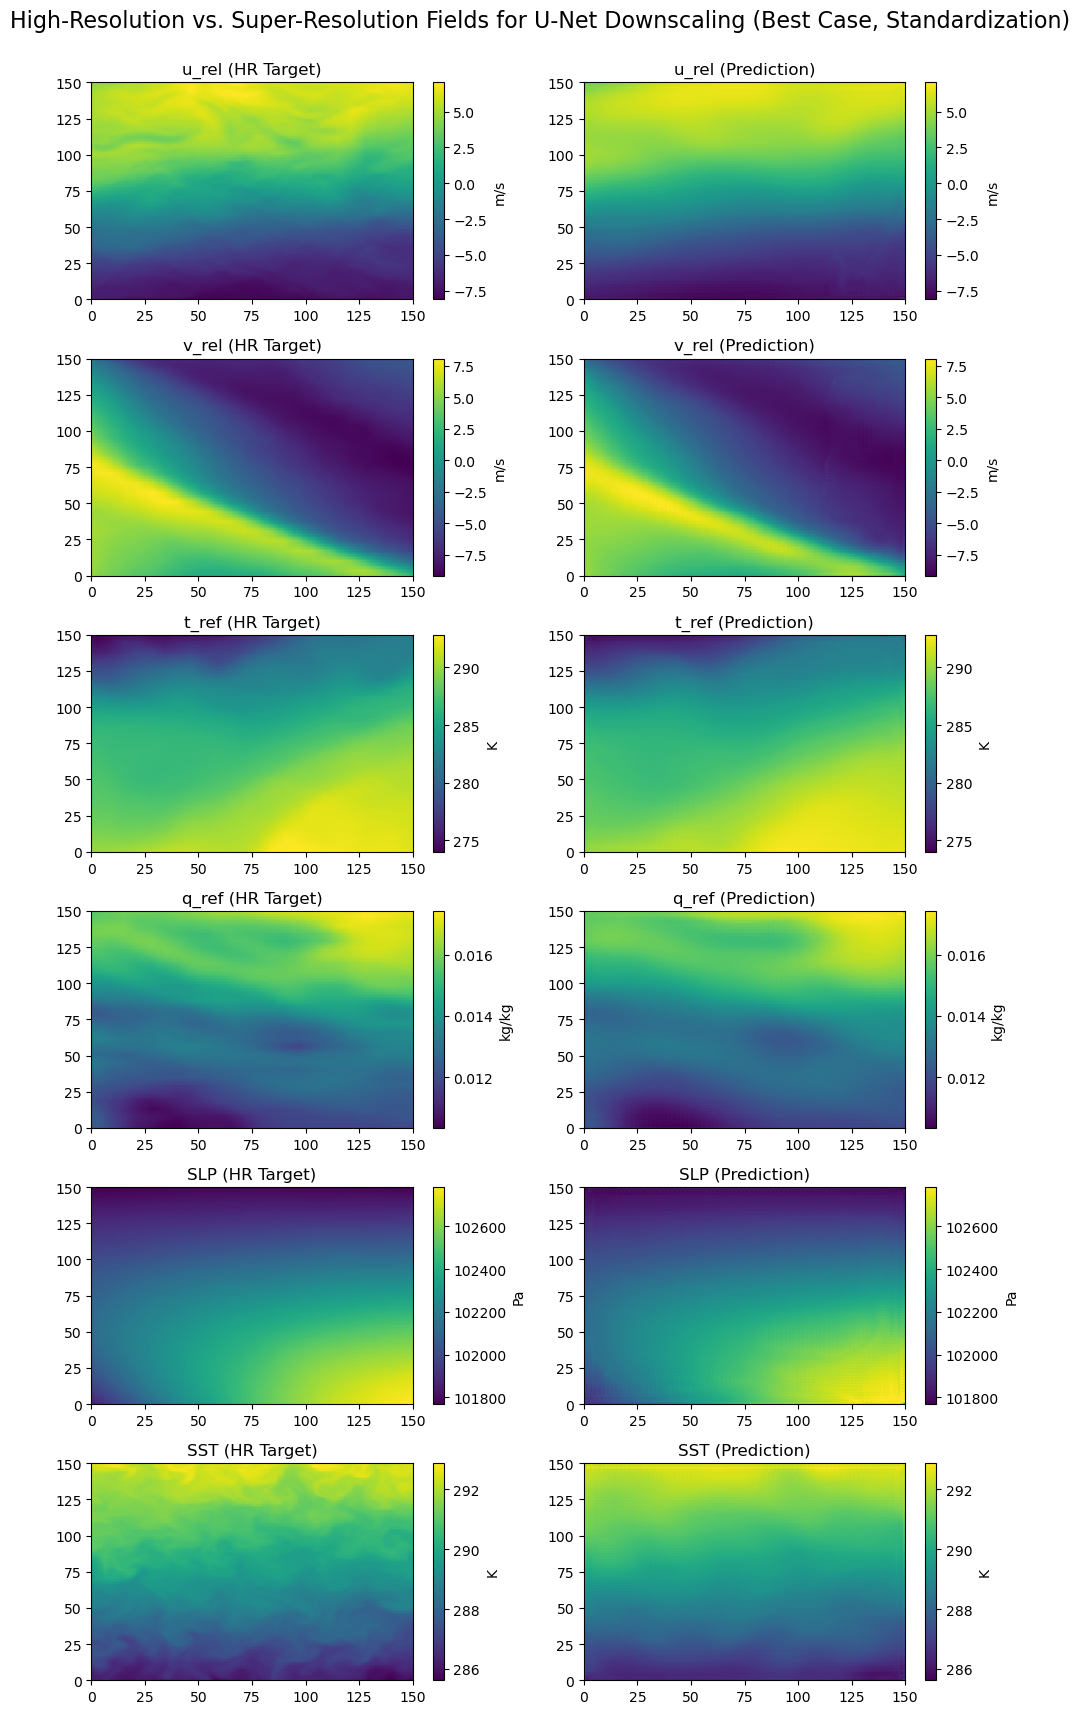

In [45]:
fig, axes = plt.subplots(6, 2, figsize=(10, 18))

vmins = [urel_HR_test[max_idx].min().values, vrel_HR_test[max_idx].min().values, tref_HR_test[max_idx].min().values,
         qref_HR_test[max_idx].min().values, slp_HR_test[max_idx].min().values, sst_HR_test[max_idx].min().values]
vmaxs = [urel_HR_test[max_idx].max().values, vrel_HR_test[max_idx].max().values, tref_HR_test[max_idx].max().values,
         qref_HR_test[max_idx].max().values, slp_HR_test[max_idx].max().values, sst_HR_test[max_idx].max().values]

# Add figure-level title
fig.suptitle("High-Resolution vs. Super-Resolution Fields for U-Net Downscaling (Best Case, Standardization)", fontsize=16, y=0.95)

# Top-left
im = axes[0, 0].pcolor(urel_HR_test[max_idx], vmin=vmins[0], vmax=vmaxs[0], shading='auto')
axes[0, 0].set_title("u_rel (HR Target)")
fig.colorbar(im, ax=axes[0, 0], label="m/s")

# Top-right
im = axes[0, 1].pcolor(urel_sr_pred[max_idx], vmin=vmins[0], vmax=vmaxs[0], shading='auto')
axes[0, 1].set_title("u_rel (Prediction)")
fig.colorbar(im, ax=axes[0, 1], label="m/s")

# Second row
im = axes[1, 0].pcolor(vrel_HR_test[max_idx], vmin=vmins[1], vmax=vmaxs[1], shading='auto')
axes[1, 0].set_title("v_rel (HR Target)")
fig.colorbar(im, ax=axes[1, 0], label="m/s")

im = axes[1, 1].pcolor(vrel_sr_pred[max_idx], vmin=vmins[1], vmax=vmaxs[1], shading='auto')
axes[1, 1].set_title("v_rel (Prediction)")
fig.colorbar(im, ax=axes[1, 1], label="m/s")

# Third row
im = axes[2, 0].pcolor(tref_HR_test[max_idx], vmin=vmins[2], vmax=vmaxs[2], shading='auto')
axes[2, 0].set_title("t_ref (HR Target)")
fig.colorbar(im, ax=axes[2, 0], label="K")

im = axes[2, 1].pcolor(tref_sr_pred[max_idx], vmin=vmins[2], vmax=vmaxs[2], shading='auto')
axes[2, 1].set_title("t_ref (Prediction)")
fig.colorbar(im, ax=axes[2, 1], label="K")

# Fourth row
im = axes[3, 0].pcolor(qref_HR_test[max_idx], vmin=vmins[3], vmax=vmaxs[3], shading='auto')
axes[3, 0].set_title("q_ref (HR Target)")
fig.colorbar(im, ax=axes[3, 0], label="kg/kg")

im = axes[3, 1].pcolor(qref_sr_pred[max_idx], vmin=vmins[3], vmax=vmaxs[3], shading='auto')
axes[3, 1].set_title("q_ref (Prediction)")
fig.colorbar(im, ax=axes[3, 1], label="kg/kg")

# Fifth row
im = axes[4, 0].pcolor(slp_HR_test[max_idx], vmin=vmins[4], vmax=vmaxs[4], shading='auto')
axes[4, 0].set_title("SLP (HR Target)")
fig.colorbar(im, ax=axes[4, 0], label="Pa")

im = axes[4, 1].pcolor(slp_sr_pred[max_idx], vmin=vmins[4], vmax=vmaxs[4], shading='auto')
axes[4, 1].set_title("SLP (Prediction)")
fig.colorbar(im, ax=axes[4, 1], label="Pa")

# Sixth row
im = axes[5, 0].pcolor(sst_HR_test[max_idx], vmin=vmins[5], vmax=vmaxs[5], shading='auto')
axes[5, 0].set_title("SST (HR Target)")
fig.colorbar(im, ax=axes[5, 0], label="K")

im = axes[5, 1].pcolor(sst_sr_pred[max_idx], vmin=vmins[5], vmax=vmaxs[5], shading='auto')
axes[5, 1].set_title("SST (Prediction)")
fig.colorbar(im, ax=axes[5, 1], label="K")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

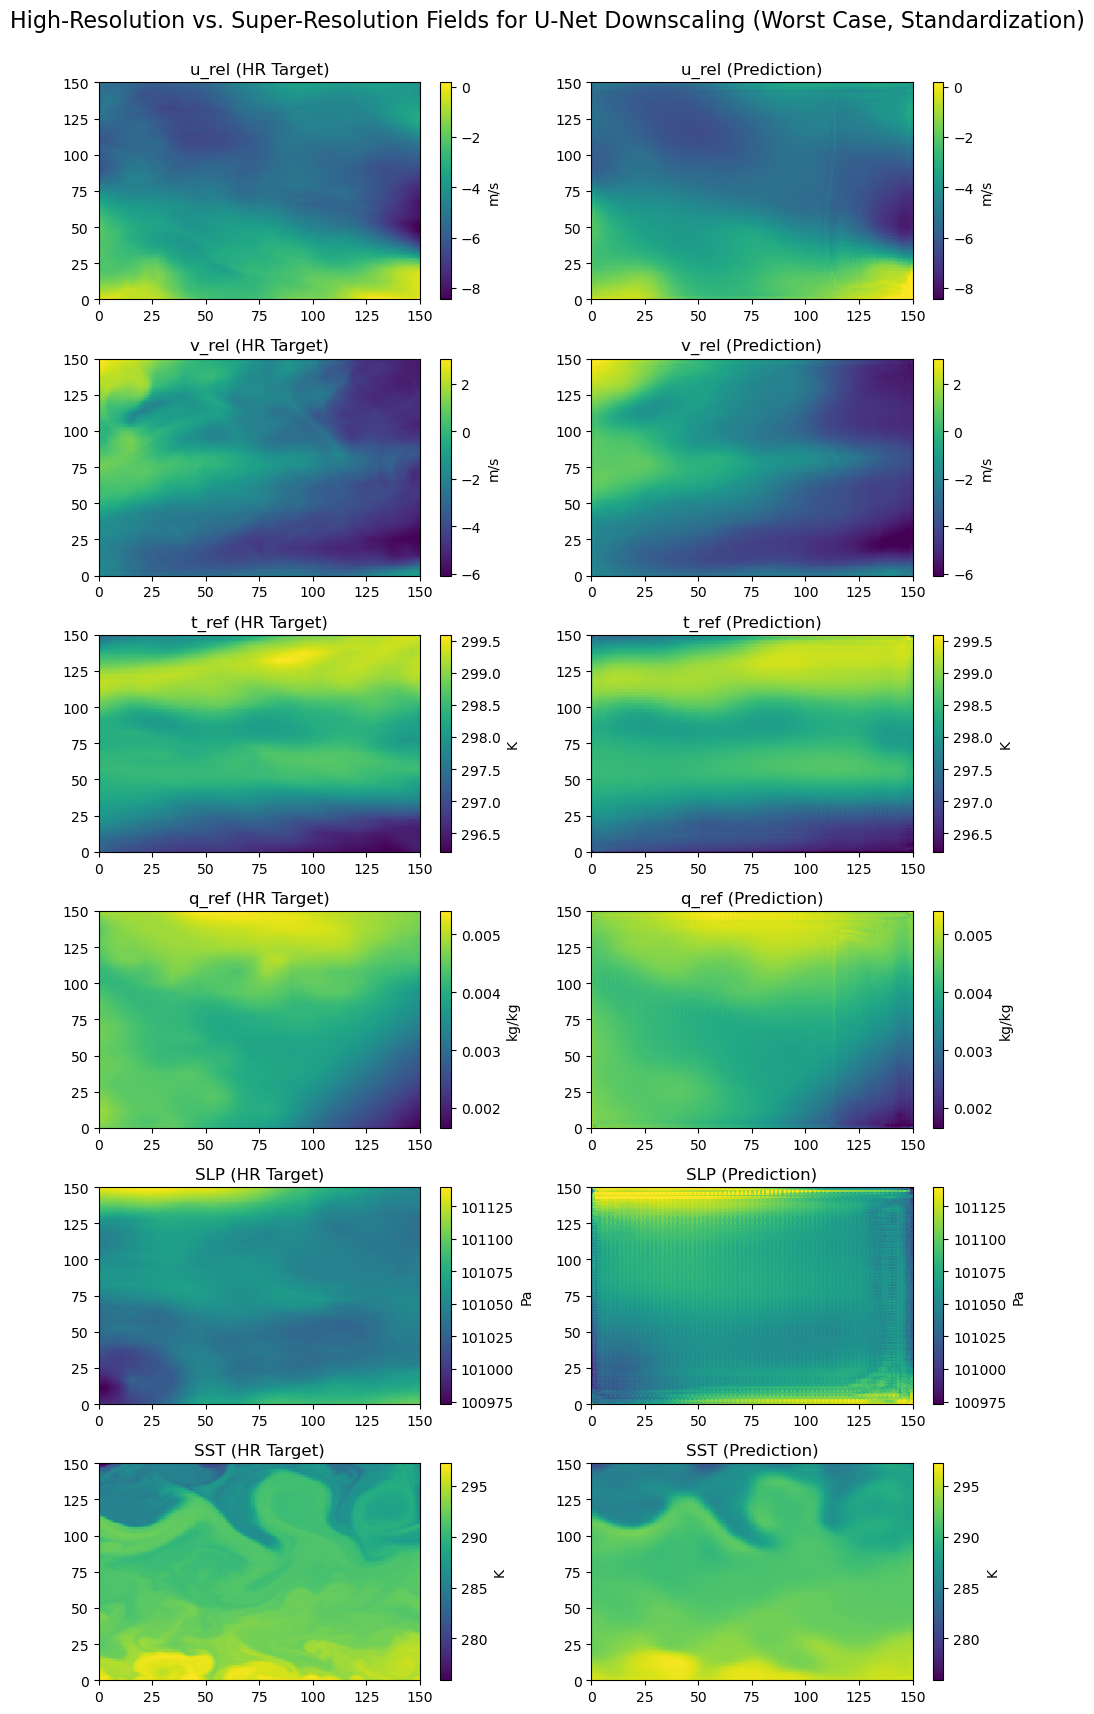

In [46]:
fig, axes = plt.subplots(6, 2, figsize=(10, 18))

vmins = [urel_HR_test[min_idx].min().values, vrel_HR_test[min_idx].min().values, tref_HR_test[min_idx].min().values,
         qref_HR_test[min_idx].min().values, slp_HR_test[min_idx].min().values, sst_HR_test[min_idx].min().values]
vmaxs = [urel_HR_test[min_idx].max().values, vrel_HR_test[min_idx].max().values, tref_HR_test[min_idx].max().values,
         qref_HR_test[min_idx].max().values, slp_HR_test[min_idx].max().values, sst_HR_test[min_idx].max().values]

# Add figure-level title
fig.suptitle("High-Resolution vs. Super-Resolution Fields for U-Net Downscaling (Worst Case, Standardization)", fontsize=16, y=0.95)

# Top-left
im = axes[0, 0].pcolor(urel_HR_test[min_idx], vmin=vmins[0], vmax=vmaxs[0], shading='auto')
axes[0, 0].set_title("u_rel (HR Target)")
fig.colorbar(im, ax=axes[0, 0], label="m/s")

# Top-right
im = axes[0, 1].pcolor(urel_sr_pred[min_idx], vmin=vmins[0], vmax=vmaxs[0], shading='auto')
axes[0, 1].set_title("u_rel (Prediction)")
fig.colorbar(im, ax=axes[0, 1], label="m/s")

# Second row
im = axes[1, 0].pcolor(vrel_HR_test[min_idx], vmin=vmins[1], vmax=vmaxs[1], shading='auto')
axes[1, 0].set_title("v_rel (HR Target)")
fig.colorbar(im, ax=axes[1, 0], label="m/s")

im = axes[1, 1].pcolor(vrel_sr_pred[min_idx], vmin=vmins[1], vmax=vmaxs[1], shading='auto')
axes[1, 1].set_title("v_rel (Prediction)")
fig.colorbar(im, ax=axes[1, 1], label="m/s")

# Third row
im = axes[2, 0].pcolor(tref_HR_test[min_idx], vmin=vmins[2], vmax=vmaxs[2], shading='auto')
axes[2, 0].set_title("t_ref (HR Target)")
fig.colorbar(im, ax=axes[2, 0], label="K")

im = axes[2, 1].pcolor(tref_sr_pred[min_idx], vmin=vmins[2], vmax=vmaxs[2], shading='auto')
axes[2, 1].set_title("t_ref (Prediction)")
fig.colorbar(im, ax=axes[2, 1], label="K")

# Fourth row
im = axes[3, 0].pcolor(qref_HR_test[min_idx], vmin=vmins[3], vmax=vmaxs[3], shading='auto')
axes[3, 0].set_title("q_ref (HR Target)")
fig.colorbar(im, ax=axes[3, 0], label="kg/kg")

im = axes[3, 1].pcolor(qref_sr_pred[min_idx], vmin=vmins[3], vmax=vmaxs[3], shading='auto')
axes[3, 1].set_title("q_ref (Prediction)")
fig.colorbar(im, ax=axes[3, 1], label="kg/kg")

# Fifth row
im = axes[4, 0].pcolor(slp_HR_test[min_idx], vmin=vmins[4], vmax=vmaxs[4], shading='auto')
axes[4, 0].set_title("SLP (HR Target)")
fig.colorbar(im, ax=axes[4, 0], label="Pa")

im = axes[4, 1].pcolor(slp_sr_pred[min_idx], vmin=vmins[4], vmax=vmaxs[4], shading='auto')
axes[4, 1].set_title("SLP (Prediction)")
fig.colorbar(im, ax=axes[4, 1], label="Pa")

# Sixth row
im = axes[5, 0].pcolor(sst_HR_test[min_idx], vmin=vmins[5], vmax=vmaxs[5], shading='auto')
axes[5, 0].set_title("SST (HR Target)")
fig.colorbar(im, ax=axes[5, 0], label="K")

im = axes[5, 1].pcolor(sst_sr_pred[min_idx], vmin=vmins[5], vmax=vmaxs[5], shading='auto')
axes[5, 1].set_title("SST (Prediction)")
fig.colorbar(im, ax=axes[5, 1], label="K")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# SGS HF Contribution Plots

In [1]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
import os
import xrft
import gcm_filters
import random
import scipy
from scipy.ndimage import convolve

warnings.filterwarnings("ignore")

from gcm_filtering import filter_inputs_dataset
from gcm_filtering import filter_inputs

import aerobulk
from aerobulk import noskin

In [2]:
def r2(y_true, y_pred):
    
    yt = y_true.reshape(-1)
    yp = y_pred.reshape(-1)
    ss_res = np.sum((yt - yp) ** 2)
    ss_tot = np.sum((yt - np.mean(yt)) ** 2)
    r2_scores = 1 - ss_res / ss_tot
    
    return r2_scores

In [3]:
def r2_per_sample(y_true, y_pred):
    n_samples = y_true.shape[0]
    r2_scores = np.empty(n_samples)
    
    for i in range(n_samples):
        yt = y_true[i].reshape(-1)
        yp = y_pred[i].reshape(-1)
        ss_res = np.sum((yt - yp) ** 2)
        ss_tot = np.sum((yt - np.mean(yt)) ** 2)
        r2_scores[i] = 1 - ss_res / ss_tot
    
    return r2_scores

## Import data

In [4]:
ds_all = xr.open_dataset(
"gs://leap-persistent/panalluri/unet_stand_fluxInputs_global.zarr", engine="zarr", chunks={}
)
ds_all

<xarray.Dataset>
Dimensions:   (time: 1314, y: 150, x: 150)
Dimensions without coordinates: time, y, x
Data variables: (12/18)
    q_ref_hr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    q_ref_lr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    q_ref_sr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    slp_hr    (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    slp_lr    (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    slp_sr    (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    ...        ...
    u_rel_hr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    u_rel_lr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    u_rel_sr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    v_rel_hr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    v_rel_lr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    v_rel_sr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>

## Stats for all samples

In [5]:
ql, qh, taux, tauy, evap =  noskin(
        ds_all.sst_sr,
        ds_all.t_ref_sr,
        ds_all.q_ref_sr,
        ds_all.u_rel_sr,
        ds_all.v_rel_sr,
        slp=ds_all.slp_sr,
        algo='ecmwf',
        zt=2,
        zu=10,
)

heatflux_sr_all = qh + ql

ql, qh, taux, tauy, evap =  noskin(
        ds_all.sst_lr,
        ds_all.t_ref_lr,
        ds_all.q_ref_lr,
        ds_all.u_rel_lr,
        ds_all.v_rel_lr,
        slp=ds_all.slp_lr,
        algo='ecmwf',
        zt=2,
        zu=10,
)

heatflux_lr_all = qh + ql

ql, qh, taux, tauy, evap =  noskin(
        ds_all.sst_hr,
        ds_all.t_ref_hr,
        ds_all.q_ref_hr,
        ds_all.u_rel_hr,
        ds_all.v_rel_hr,
        slp=ds_all.slp_hr,
        algo='ecmwf',
        zt=2,
        zu=10,
)

heatflux_hr_all = qh + ql

In [6]:
# Make a Dataset
ds_heatflux = xr.Dataset()

# Manually add variables
ds_heatflux["heatflux_hr"] = (("time", "yt_ocean", "xt_ocean"), heatflux_lr_all.values)
ds_heatflux["heatflux_lr"] = (("time", "yt_ocean", "xt_ocean"), heatflux_hr_all.values)
ds_heatflux["heatflux_sr"] = (("time", "yt_ocean", "xt_ocean"), heatflux_sr_all.values)

ds_heatflux

<xarray.Dataset>
Dimensions:      (time: 1314, yt_ocean: 150, xt_ocean: 150)
Dimensions without coordinates: time, yt_ocean, xt_ocean
Data variables:
    heatflux_hr  (time, yt_ocean, xt_ocean) float64 -160.3 -159.4 ... 155.3
    heatflux_lr  (time, yt_ocean, xt_ocean) float64 -178.7 -177.6 ... 155.2
    heatflux_sr  (time, yt_ocean, xt_ocean) float64 -132.2 -162.1 ... 110.5

In [7]:
print("Filtering model")
heatflux_smooth = filter_inputs_dataset(ds_heatflux, ['yt_ocean', 'xt_ocean'], filter_scale=50, filter_type='gaussian')
heatflux_smooth

Filtering model


<xarray.Dataset>
Dimensions:      (time: 1314, yt_ocean: 150, xt_ocean: 150)
Dimensions without coordinates: time, yt_ocean, xt_ocean
Data variables:
    heatflux_hr  (time, yt_ocean, xt_ocean) float64 -317.3 -313.8 ... 203.3
    heatflux_lr  (time, yt_ocean, xt_ocean) float64 -347.9 -343.0 ... 240.6
    heatflux_sr  (time, yt_ocean, xt_ocean) float64 -338.0 -333.5 ... 240.4
Attributes:
    filter_scale:  50
    filter_type:   gaussian

In [8]:
HF_SGS_all_pred = heatflux_smooth.heatflux_sr - heatflux_smooth.heatflux_lr
HF_SGS_all_true = heatflux_smooth.heatflux_hr - heatflux_smooth.heatflux_lr

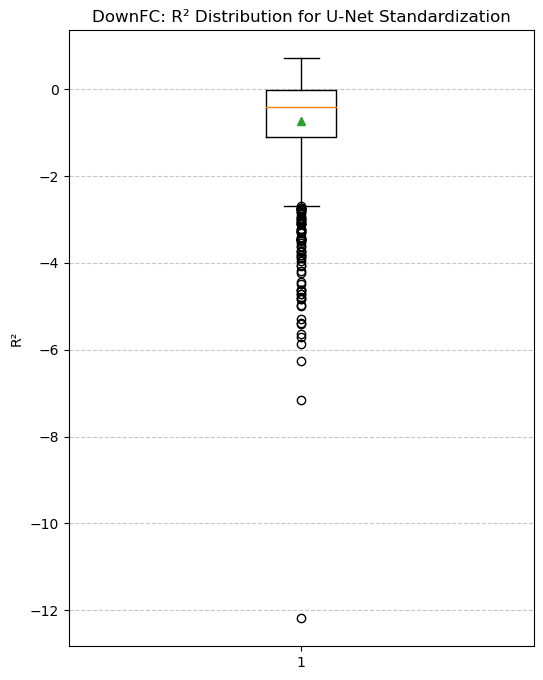

In [9]:
r2_all = r2_per_sample(HF_SGS_all_true.values, HF_SGS_all_pred.values)
plt.figure(figsize=(6, 8))
plt.boxplot(r2_all, vert=True, showmeans=True)
plt.ylabel("R²")
plt.title("DownFC: R² Distribution for U-Net Standardization")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Best case results (from SGS HF R2 values)

In [10]:
arr = r2_all

max_val = arr.max()        # get the minimum value
max_idx = arr.argmax()     # get the index of the minimum value

print("Maximum R2 value:", max_val)
print("Index of maximum:", max_idx)

Maximum R2 value: 0.7121749789970582
Index of maximum: 721


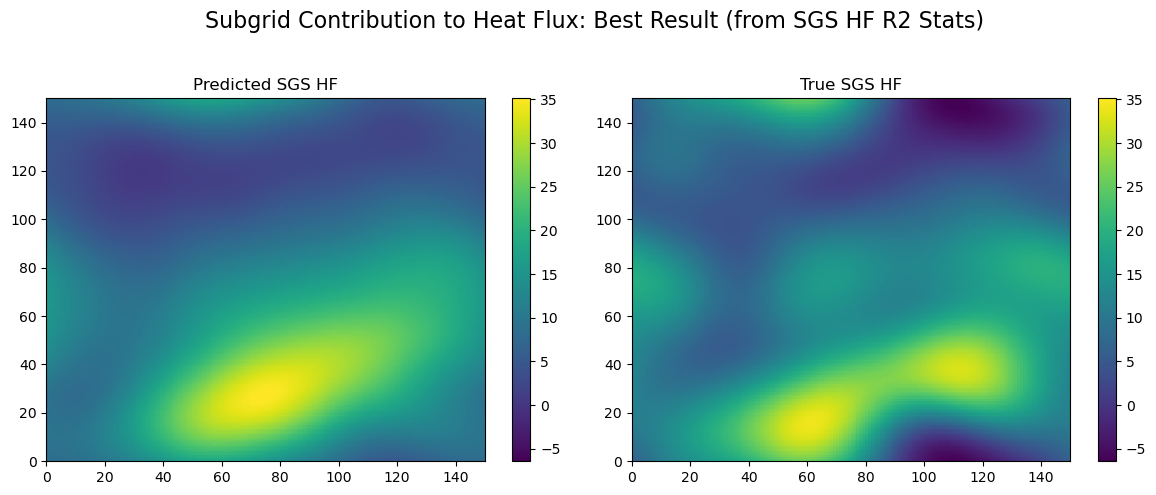

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

data1 = HF_SGS_all_pred.isel(time=max_idx)
data2 = HF_SGS_all_true.isel(time=max_idx)
vmin = min(data1.min(), data2.min()).item()
vmax = max(data1.max(), data2.max()).item()

# Plot predicted
im0 = axes[0].pcolor(data1, vmin=vmin, vmax=vmax)
axes[0].set_title('Predicted SGS HF')
fig.colorbar(im0, ax=axes[0])

# Plot true
im1 = axes[1].pcolor(data2, vmin=vmin, vmax=vmax)
axes[1].set_title('True SGS HF')
fig.colorbar(im1, ax=axes[1])

# Add supertitle
fig.suptitle('Subgrid Contribution to Heat Flux: Best Result (from SGS HF R2 Stats)', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for supertitle
plt.show()

## Worst case results (from SGS HF R2 values)

In [12]:
arr = r2_all

min_val = arr.min()        # get the minimum value
min_idx = arr.argmin()     # get the index of the minimum value

print("Minimum R2 value:", min_val)
print("Index of minimum:", min_idx)

Minimum R2 value: -12.185778915071808
Index of minimum: 504


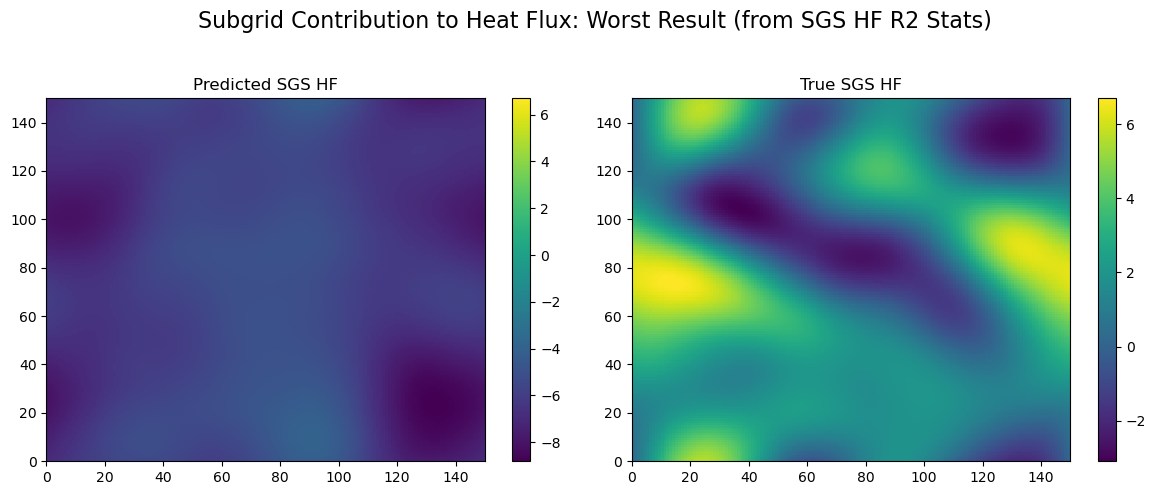

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

data1 = HF_SGS_all_pred.isel(time=min_idx)
data2 = HF_SGS_all_true.isel(time=min_idx)
vmin = min(data1.min(), data2.min()).item()
vmax = max(data1.max(), data2.max()).item()

# Plot predicted
im0 = axes[0].pcolor(data1, vmin=vmin, vmax=vmax)
axes[0].set_title('Predicted SGS HF')
fig.colorbar(im0, ax=axes[0])

# Plot true
im1 = axes[1].pcolor(data2) #, vmin=vmin, vmax=vmax)
axes[1].set_title('True SGS HF')
fig.colorbar(im1, ax=axes[1])

# Add supertitle
fig.suptitle('Subgrid Contribution to Heat Flux: Worst Result (from SGS HF R2 Stats)', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for supertitle
plt.show()

## Best Case Results (from downscaling R2 values)

In [14]:
max_idx_down = 110
min_idx_down = 91

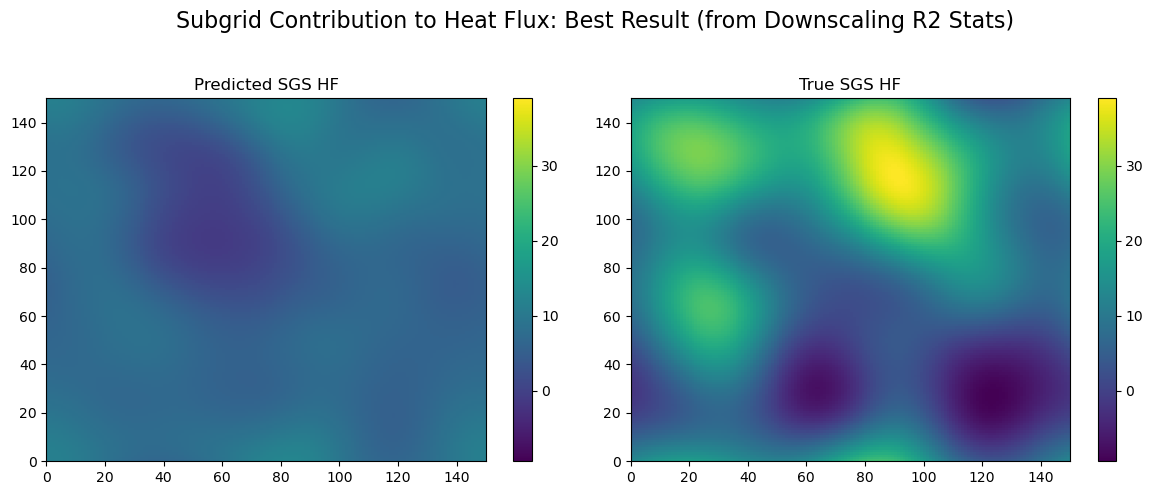

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

data1 = HF_SGS_all_pred.isel(time=max_idx_down)
data2 = HF_SGS_all_true.isel(time=max_idx_down)
vmin = min(data1.min(), data2.min()).item()
vmax = max(data1.max(), data2.max()).item()

# Plot predicted
im0 = axes[0].pcolor(data1, vmin=vmin, vmax=vmax)
axes[0].set_title('Predicted SGS HF')
fig.colorbar(im0, ax=axes[0])

# Plot true
im1 = axes[1].pcolor(data2, vmin=vmin, vmax=vmax)
axes[1].set_title('True SGS HF')
fig.colorbar(im1, ax=axes[1])

# Add supertitle
fig.suptitle('Subgrid Contribution to Heat Flux: Best Result (from Downscaling R2 Stats)', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for supertitle
plt.show()

In [16]:
data1 = HF_SGS_all_pred.isel(time=max_idx_down)
data2 = HF_SGS_all_true.isel(time=max_idx_down)
r2(data1.values, data2.values)

-15.670568859992176

## Worst Case Results (from downscaling R2 values)

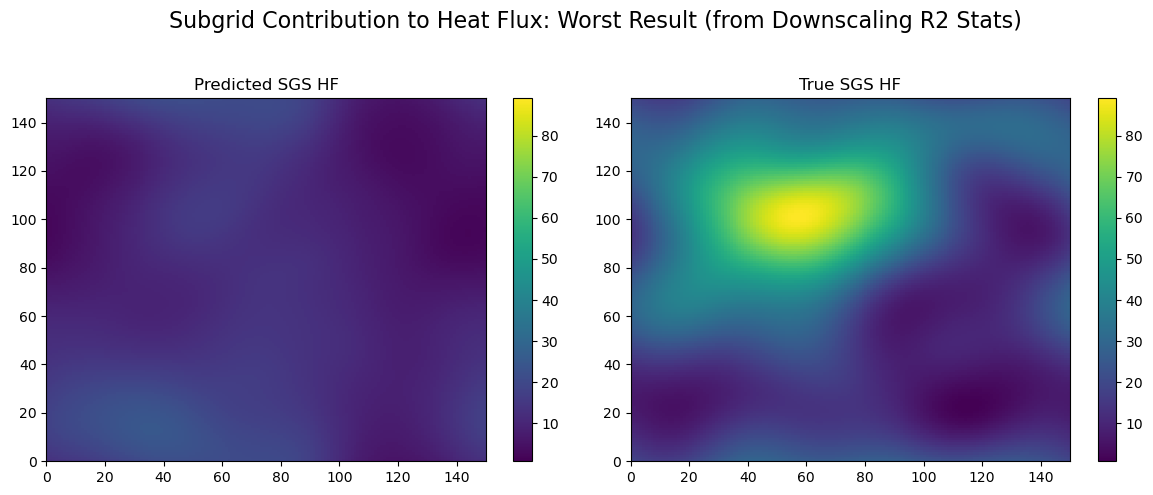

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

data1 = HF_SGS_all_pred.isel(time=min_idx_down)
data2 = HF_SGS_all_true.isel(time=min_idx_down)
vmin = min(data1.min(), data2.min()).item()
vmax = max(data1.max(), data2.max()).item()

# Plot predicted
im0 = axes[0].pcolor(data1, vmin=vmin, vmax=vmax)
axes[0].set_title('Predicted SGS HF')
fig.colorbar(im0, ax=axes[0])

# Plot true
im1 = axes[1].pcolor(data2, vmin=vmin, vmax=vmax)
axes[1].set_title('True SGS HF')
fig.colorbar(im1, ax=axes[1])

# Add supertitle
fig.suptitle('Subgrid Contribution to Heat Flux: Worst Result (from Downscaling R2 Stats)', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for supertitle
plt.show()

In [18]:
data1 = HF_SGS_all_pred.isel(time=min_idx_down)
data2 = HF_SGS_all_true.isel(time=min_idx_down)
r2(data1.values, data2.values)

-24.868265108163662